This is the ACF and Dlocal line plot.

Continued from `p2021-0617a_ACF-Dlocal_plots.ipynb`.

The ACF data was prepared by notebooks in the `silicate_md` repo, which were then copied to the location indicated here:

- `p20201207a_get_acf_data.ipynb`
- `p2021-0201a_another_ACF_extraction.ipynb`


## Setup

In [1]:
import os
import os.path as osp

In [2]:
import operator
import itertools

In [3]:
from datetime import datetime

In [4]:
import numpy as np

In [5]:
import pandas as pd

In [6]:
import matplotlib.pyplot as plt

In [7]:
%matplotlib inline

In [8]:
import matplotlib as mpl

In [9]:
#Uncomment for print
# mpl.rcParams['figure.dpi']= 300

In [10]:
#Uncomment for presentation
# mpl.rcParams['xtick.labelsize']="xx-large"
# mpl.rcParams['ytick.labelsize']="xx-large"

In [11]:
##from matplotlib.gridspec import GridSpec #Not used at present but potentially useful

In [12]:
from matplotlib.colors import BoundaryNorm

In [13]:
import simproc

In [14]:
import simproc.requesthandler.yaml_manager as yaml_manager
import simproc.requesthandler.pickle_manager as pickle_manager
import simproc.requesthandler.locators as locators

## Constants

In [15]:
taglist=['12A','16A','20A','27pct','50pct','na_27pct']

In [16]:
dlocal_comp_list=["xx","yy","zz","avg"]

In [17]:
dlocal_fname_tmpl="D{comp}_{tag}_nd.csv"

In [18]:
pmf_fname_tmpl="pmf_{tag}_nd.csv"

In [19]:
wdens_fname_tmpl="density_Xplane_{mtag}.pkl"

In [20]:
bbox_fname_tmpl="bbox_{tag}.csv"

In [21]:
plot_fname_tmpl="ACF_Dlocal_{}.png"

In [22]:
acf_df_files={'channel':'acf_curves.csv.xz','bulk':'bulk_acf.csv.xz'}

In [23]:
SELTOL=1e-6

In [24]:
#For print
# font_settings={
#   "cbar_wdens": 16,
#   "cbar_dratio": 32,
#   "cbar_pmf": 16,
#   "axlabels": 12,
#   "axtitle": 14,
# }
#Intermediate
# font_settings={
#   "cbar_wdens": 20,
#   "cbar_dratio": 40,
#   "cbar_pmf": 20,
#   "axlabels": 16,
#   "axtitle": 18,
# }
#For presentation
# font_settings={
#   "cbar_wdens": 24,
#   "cbar_dratio": 40,
#   "cbar_pmf": 24,
#   "axlabels": 24,
#   "axtitle": 24,
# }

## Data folder

In [25]:
datadir=osp.abspath("../silicate")
assert osp.isdir(datadir)

In [26]:
o=locators.SetDataFolder(datafolder=datadir)

## Locators

In [27]:
#locators.folder_structure.keys()

In [28]:
locators.folder_structure.update(Unprocessed=['inputs','unprocessed'])

In [29]:
locators.folder_structure.update(Processed=['inputs','processed'])

In [30]:
locators.folder_structure.update(Manual=['inputs','manual'])

In [31]:
locators.folder_structure.update(ACF_df=['inputs','ACF_df'])

In [32]:
Unprocessed=lambda fname: self.renderstr(locators.Unprocessed(fname))

In [33]:
Processed=lambda fname: self.renderstr(locators.Processed(fname))

In [34]:
Manual=lambda fname: self.renderstr(locators.Manual(fname))

In [35]:
ACF_df=lambda fname: self.renderstr(locators.ACF_df(fname))

## Dummy request for loading data

In [36]:
self=simproc.requesthandler.request.Request(name="ypress.plotting")

## Data file names and paths

Manual data

In [37]:
manualdata_fpath=Manual('other_input_values.yaml')
assert osp.isfile(manualdata_fpath)

$D_{\text{local}}$

In [38]:
dlocal_fpaths={}
for tag in taglist:
  dlocal_fpaths[tag]={comp:Processed(dlocal_fname_tmpl.format(tag=tag,comp=comp)) \
                        for comp in dlocal_comp_list}

In [39]:
dloc_existence_list=[]
for fdict in dlocal_fpaths.values():
  dloc_existence_list+=[osp.isfile(fpath) for fpath in fdict.values()]
assert all(dloc_existence_list)

PMF

In [40]:
pmf_fpaths={tag:Processed(pmf_fname_tmpl.format(tag=tag)) for tag in taglist}

In [41]:
pmf_existence_list=[osp.isfile(fpath) for fpath in pmf_fpaths.values()]
assert all(pmf_existence_list)

Water density

Paths require manual data; see below.

Bounding Box data

In [42]:
bbox_fpaths={tag:Processed(bbox_fname_tmpl.format(tag=tag)) for tag in taglist}

Plot output folder

In [43]:
postproc_top=osp.join(datadir,"postproc","notebooks")

In [44]:
assert osp.isdir(postproc_top)

ACF curves

In [45]:
acf_fpaths={kind:ACF_df(fname) for kind,fname in acf_df_files.items()}

In [46]:
acf_existence_list=[osp.isfile(fpath) for fpath in acf_fpaths.values()]
assert all(acf_existence_list)

## Read the input data

Manual

In [47]:
other_input_values=yaml_manager.readfile(manualdata_fpath)

In [48]:
meshes_by_tag=other_input_values["meshes_by_tag"]

$D_\text{local}$

In [49]:
dlocal={}
for tag,pathdict in dlocal_fpaths.items():
  dlocal[tag]= {comp:pd.read_csv(pathdict[comp]) for comp in dlocal_comp_list}

PMF

In [50]:
pmf={tag:pd.read_csv(fpath) for tag,fpath in pmf_fpaths.items()}

Water density

In [51]:
wdens_fpaths={tag:Unprocessed(wdens_fname_tmpl.format(mtag=meshes_by_tag[tag])) for tag in taglist}

In [52]:
wdens_existence_list=[osp.isfile(fpath) for fpath in wdens_fpaths.values()]
assert all(wdens_existence_list)

In [53]:
wdens={tag:pickle_manager.readfile(fpath) for tag,fpath in wdens_fpaths.items()}

Bounding box data

In [54]:
bboxes={tag:pd.read_csv(fpath,index_col=0) for tag,fpath in bbox_fpaths.items()}

ACF curves

In [55]:
acf_df=pd.read_csv(acf_fpaths['channel'])

In [56]:
acf_df.columns

Index(['t', '4.75', '5.05', '5.35'], dtype='object')

In [57]:
acf_zvals=list(acf_df.columns[1:])

In [58]:
acf_bulk=pd.read_csv(acf_fpaths['bulk'])

In [59]:
acf_bulk.columns

Index(['t', 'x', 'y', 'z'], dtype='object')

## Output plot paths

In [60]:
datestr=datetime.now().strftime("%Y_%m%d")
datestr

'2021_0918'

In [61]:
outdir=osp.join(postproc_top,datestr)

In [62]:
if not osp.isdir(outdir):
  os.makedirs(outdir)
assert osp.isdir(outdir)

## Constants and Functions for plotting

In [63]:
def select_by_coord(inframe,col,val,tol=SELTOL):
  cond=(inframe[col]<(val+tol)) & (inframe[col]>(val-tol))
  sel=inframe[cond]
  return sel

In [64]:
def average_across(inframe,selcol,avgcol,tol=SELTOL):
  vlist=list(inframe[selcol].unique())
  vlist.sort()
  rows=[]
  for vv in vlist:
    subset=select_by_coord(inframe,selcol,vv,tol)
    avg_val=subset[avgcol].mean()
    rows.append((vv,avg_val))
  outframe=pd.DataFrame(rows,columns=[selcol,avgcol])
  return outframe

In [65]:
def make_stairsteps(edgearr,valarr):
  xvals=[edgearr[0]]
  yvals=[valarr[0]]
  for idx in range(len(valarr)-1):
    xvals+=[edgearr[idx+1],edgearr[idx+1]]
    yvals+=[valarr[idx],valarr[idx+1]]
  xvals.append(edgearr[-1])
  yvals.append(valarr[-1])
  return np.array(xvals),np.array(yvals)

In [66]:
def unpack_wdens(wdens_dict):
  return wdens_dict["grid"], wdens_dict["edges"]

## Plots

We're going to use the 16A channel for this.

In [67]:
tag="16A"

In [68]:
df_pmf=pmf[tag]

In [69]:
df_dlocal=dlocal[tag]["xx"]

In [70]:
grid,edges=unpack_wdens(wdens[tag])

In [71]:
bbox=bboxes[tag]

In [72]:
bbox

,Xmin,Xmax,Xspan,Ymin,Ymax,Yspan,Zmin,Zmax,Zspan
mesh,5.70,5.80,0.1,4.900,5.500,0.60,4.700,6.300,1.60
limits,5.75,5.75,0.0,4.900,5.500,0.60,4.700,6.400,1.70
Dxx,5.75,5.75,0.0,4.900,5.450,0.55,4.700,6.350,1.65
Dyy,5.75,5.75,0.0,4.900,5.450,0.55,4.700,6.350,1.65
Dzz,5.75,5.75,0.0,4.900,5.450,0.55,4.700,6.350,1.65
Davg,5.75,5.75,0.0,4.900,5.450,0.55,4.700,6.350,1.65
pmf,5.75,5.75,0.0,4.875,5.525,0.65,4.675,6.425,1.75


In [73]:
meshbox=bbox.loc['mesh',:]
meshbox

Xmin     5.7
Xmax     5.8
Xspan    0.1
Ymin     4.9
Ymax     5.5
Yspan    0.6
Zmin     4.7
Zmax     6.3
Zspan    1.6
Name: mesh, dtype: float64

In [74]:
Ymid=(meshbox["Ymax"]+meshbox["Ymin"])/2.0
Ymid

5.2

In [75]:
pmf_unique_y=df_pmf["y"].unique()
pmf_unique_y

array([4.875, 4.925, 4.975, 5.025, 5.075, 5.125, 5.175, 5.225, 5.275,
       5.325, 5.375, 5.425, 5.475, 5.525])

In [76]:
sely_pmf=pmf_unique_y[6]
sely_pmf

5.175

In [77]:
dlocal_unique_y=df_dlocal["y"].unique()
dlocal_unique_y

array([4.9 , 4.95, 5.  , 5.05, 5.1 , 5.15, 5.2 , 5.25, 5.3 , 5.35, 5.4 ,
       5.45])

In [78]:
sely_dlocal=dlocal_unique_y[6]
sely_dlocal

5.2

In [79]:
sel_dlocal=select_by_coord(df_dlocal,"y",sely_dlocal)
sel_dlocal.columns

Index(['x', 'y', 'z', 'Dxx'], dtype='object')

In [80]:
averaged_dlocal=average_across(df_dlocal,'z','Dxx')
averaged_dlocal.columns

Index(['z', 'Dxx'], dtype='object')

In [81]:
example_indices=[1,7,13]

In [82]:
example_z=[sel_dlocal['z'].iloc[idx] for idx in example_indices]
example_z

[4.75, 5.05, 5.3500000000000005]

In [83]:
example_D=[sel_dlocal['Dxx'].iloc[idx] for idx in example_indices]
example_D

[0.2289754458688373, 0.6724962067250424, 1.0538256853740922]

In [84]:
acf_fmts=""

In [85]:
ystr="$D_{{xx}}$ for $y$={y:0.1f} nm".format(y=sely_dlocal)
ystr

'$D_{xx}$ for $y$=5.2 nm'

In [86]:
#Series for bulk dlocal on the right panel
bulk_d_x=[4.5,6.5]
bulk_d_y=[1.0,1.0]

In [87]:
#Colors for the left panel
color_list=["C1","C2","C5"]

In [88]:
#Label for bulk simulation on the left panel
bulk_sim_label="Bulk water:  normalized $D_{xx}$=1.00"

/tmp/ipykernel_10345/1986430052.py:4: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "k-" (-> linestyle='-'). The keyword argument will take precedence.
  o=ax.plot(acf_bulk['t'],acf_bulk['x'],'k-',label=bulk_sim_label,color="blue",linestyle="dotted")
/tmp/ipykernel_10345/1986430052.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  o=ax.plot(acf_bulk['t'],acf_bulk['x'],'k-',label=bulk_sim_label,color="blue",linestyle="dotted")


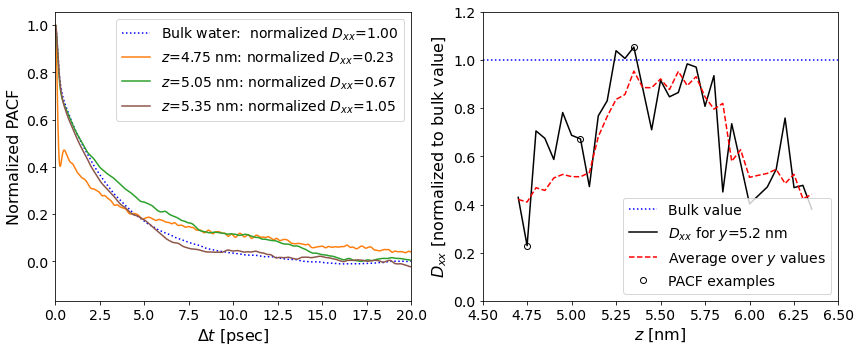

In [89]:
fig,axlist=plt.subplots(1,2,figsize=(12,5))
#ACFs
ax=axlist[0]
o=ax.plot(acf_bulk['t'],acf_bulk['x'],'k-',label=bulk_sim_label,color="blue",linestyle="dotted")
for idx,zstr in enumerate(acf_zvals):
  lblstr="$z$={zstr} nm: normalized $D_{{xx}}$={Dxx:0.2f}".format(zstr=zstr,Dxx=example_D[idx])
  o=ax.plot(acf_df['t'],acf_df.iloc[:,idx+1],label=lblstr,color=color_list[idx])
o=ax.set_xlim(0,20.0)
o=ax.set_xlabel("$\Delta t$ [psec]",fontsize=16)
o=ax.set_ylabel("Normalized PACF",fontsize=16)
o=ax.tick_params(axis='x', labelsize=14)
o=ax.tick_params(axis='y', labelsize=14)
o=ax.legend(loc="upper right",fontsize=14)
#D local
ax=axlist[1]
o=ax.plot(bulk_d_x,bulk_d_y,label="Bulk value",color="blue",linestyle="dotted")
o=ax.plot(sel_dlocal['z'],sel_dlocal["Dxx"],"k-",label=ystr)
o=ax.plot(averaged_dlocal['z'],averaged_dlocal["Dxx"],"r--",label="Average over $y$ values")
o=ax.plot(example_z,example_D,"ko",label="PACF examples",mfc='none')
o=ax.set_xlabel("$z$ [nm]",fontsize=16)
o=ax.set_ylabel("$D_{xx}$ [normalized to bulk value]",fontsize=16)
o=ax.tick_params(axis='x', labelsize=14)
o=ax.tick_params(axis='y', labelsize=14)
o=ax.set_xlim(4.5,6.5)
o=ax.set_ylim(0,1.2)
o=ax.legend(loc="lower right",fontsize=14)
#Done
fig.tight_layout()
plot_fpath=osp.join(outdir,plot_fname_tmpl.format("plot"))
fig.savefig(plot_fpath,dpi=150)